## Import important libraries

In [294]:
import pandas as pd # Used for dataframes
import numpy as np # Used for arrays and their operations
from bs4 import BeautifulSoup # Used for parsing and scraping data
from bs4 import SoupStrainer
import re
import requests # Used for connecting to website
import csv
import io
import geocoder # import geocoder
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

## Get data from various sources

#### Get population data on major Canadian cities

In [70]:
# Connect to website and start scraping data
source = requests.get('https://www.todocanada.ca/population-canadas-cities-2016-census/').content
# Get formatted code of website
soup = BeautifulSoup(source, 'lxml')
soup.prettify()

'<!DOCTYPE html>\n<!--[if lt IE 7 ]> <html class="ie6"> <![endif]-->\n<!--[if IE 7 ]>    <html class="ie7"> <![endif]-->\n<!--[if IE 8 ]>    <html class="ie8"> <![endif]-->\n<!--[if IE 9 ]>    <html class="ie9"> <![endif]-->\n<!--[if (gt IE 9)|!(IE)]><!-->\n<!--<![endif]-->\n<html>\n <head>\n  <script async="" src="//pagead2.googlesyndication.com/pagead/js/adsbygoogle.js">\n  </script>\n  <script>\n   (adsbygoogle = window.adsbygoogle || []).push({\r\n    google_ad_client: "ca-pub-8228390839633607",\r\n    enable_page_level_ads: true\r\n  });\n  </script>\n  <link href="https://fonts.googleapis.com/css?family=Open+Sans" rel="stylesheet" type="text/css"/>\n  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>\n  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>\n  <meta content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=1, user-scalable=0" name="viewport"/>\n  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>\n  <titl

#### Information we need is in table, so scrape data from there

In [91]:
# Iterate through table and assign all data to empty lists
#
city_name = []
city_size = []
post_table = soup.find_all("table", class_="")
post_table = post_table[0]
# Loop for city names
for row in post_table.find_all('tr'):
    for elem in row.find_all('td'):
        val = elem.text.split('\n')[0]
        city_name.append(val)
# Loop for city sizes
for row in post_table.find_all('tr'):
    for elem in row.find_all('p'):
        val = elem.text.split('\n')[0]
        city_size.append(val)

In [129]:
# Go through list and adjust values so they line up properly
name = city_name[4::2]
name
# Now append column data to dictionary
pop_dict = {'City':name, 'Population':city_size}

#### Create pandas dataframe using dictionary

In [130]:
df_pop = pd.DataFrame.from_dict(pop_dict)
df_pop.head()

,City,Population
0,"Toronto, Ont.",5928040
1,"Montréal, Que.",4098927
2,"Vancouver, B.C.",2463431
3,"Calgary, Alta.",1392609
4,"Ottawa–Gatineau, Que. and Ont.",1323783


In [131]:
# Check size of dataframe
df_pop.shape

(35, 2)

#### Isolate the citites of Toronto and Calgary from dataframe

In [132]:
# Select rows
df_cmpr = df_pop.iloc[0:4]
# Remove unnecessary rows
df_cmpr.drop(index=[1, 2], inplace=True)

In [133]:
df_cmpr.reset_index(drop=True, inplace=True)

In [134]:
df_cmpr

,City,Population
0,"Toronto, Ont.",5928040
1,"Calgary, Alta.",1392609


#### Get greenhouse gas data for Calgary and read into pandas dataframe

In [135]:
cal_url = 'https://data.calgary.ca/resource/m7gu-3xk5.csv'
ghg_cal = pd.read_csv(cal_url)
ghg_cal.head()

,year,sector,emissions_source,tonnes_co2e,sector_emissions_source
0,2005,Stationary Energy,Commercial Buildings,7190415,SE Commercial Buildings
1,2005,Stationary Energy,Industrial Buildings,0,SE Industrial Buildings
2,2005,Stationary Energy,Institutional Buildings,0,SE Institutional Buildings
3,2005,Stationary Energy,Residential Buildings,3968175,SE Residential Buildings
4,2006,Stationary Energy,Commercial Buildings,7321480,SE Commercial Buildings


Check size of dataframe

In [138]:
ghg_cal.shape

(117, 5)

#### Get greenhouse gas data for Toronto and read into pandas dataframe

##### Data was available in PDF and other difficult formats to work with, so I downloaded data as PDF and covnerted it to a CSV file using the website below.

In [272]:
# Data sourced from this website and downloaded as PDF, based on 2016 data
source2 = 'https://www.c40.org/research/open_data/5'
# Website used to convert PDF to CSV
conv = 'https://pdftables.com'
# I fixed formatting in CSV file to make it easier to read into dataframe
# Open downloaded file into pandas Dataframe
with open(r'C:\Users\ahmed\OneDrive\Documents\City Overview.csv', 'r') as co:
    ghg_tor = pd.read_csv(co)
ghg_tor

,Sector,Sub-Sector,Scope 1,Scope 2,Scope 3,Grand Total
0,Stationary,Residential Buildings,"3,768,448","181,225","20,136","3,969,808"
1,Stationary,Commercial and institutional buildings and fac...,"2,380,666","608,547","67,616","3,056,830"
2,Stationary,Manufacturing industries and construction,"937,501","89,239","9,915","1,036,655"
3,Stationary,Energy industries,NaN,NaN,NaN,NaN
4,Stationary,Energy generation supplied to the grid,"388,069",NaN,NaN,"388,069"
5,Stationary,"Agriculture, forestry, and fishing activities",NaN,0,NaN,NaN
6,Stationary,Non-specified sources,NaN,NaN,NaN,NaN
7,Stationary,"Fugitive emissions from mining, processing, st...",NaN,NaN,NaN,NaN
8,Stationary,Fugitive emissions from oil and natural gas sy...,"85,645",NaN,NaN,"85,645"
9,Transportation,On-road Transportation,"6,266,014",NaN,"19,066","6,285,080"


In [275]:
# Replace NaN values
ghg_tor = ghg_tor.fillna(0)

In [276]:
ghg_tor.head()

,Sector,Sub-Sector,Scope 1,Scope 2,Scope 3,Grand Total
0,Stationary,Residential Buildings,"3,768,448","181,225","20,136","3,969,808"
1,Stationary,Commercial and institutional buildings and fac...,"2,380,666","608,547","67,616","3,056,830"
2,Stationary,Manufacturing industries and construction,"937,501","89,239","9,915","1,036,655"
3,Stationary,Energy industries,0,0,0,0
4,Stationary,Energy generation supplied to the grid,"388,069",0,0,"388,069"


#### Get methods of commuting for Calgary and Toronto and read into pandas dataframe

In [383]:
# download data from here
source3 = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=CMACA&Code1=535&Geo2=CMACA&Code2=825&Data=Count&SearchText=calgary&SearchType=Begins&SearchPR=01&B1=Journey%20to%20work&TABID=1'
# I changed format in CSV file before opening file here
# Open file and read into pandas dataframe
with open(r'C:\Users\ahmed\OneDrive\Documents\Census_cal_and_Tor.csv', 'r') as cp:
    comm = pd.read_csv(cp)
comm.head()

,Topic,Characteristics,Note,Total,Flag_Total,Male,Flag_Male,Female,Flag_Female,Total.1,Flag_Total.1,Male.1,Flag_Male.1,Female.1,Flag_Female.1
0,Commuting destination,Total,NaN,2400850.0,NaN,1175685.0,NaN,1225160.0,NaN,582020.0,NaN,287545.0,NaN,294470.0,NaN
1,Commuting destination,CSD,NaN,1353665.0,NaN,614770.0,NaN,738890.0,NaN,505650.0,NaN,243660.0,NaN,261985.0,NaN
2,Commuting destination,Diff. CSD,NaN,243620.0,NaN,119725.0,NaN,123890.0,NaN,62840.0,NaN,34395.0,NaN,28450.0,NaN
3,Commuting destination,Diff. CSD/CS,NaN,798155.0,NaN,437940.0,NaN,360215.0,NaN,10070.0,NaN,7365.0,NaN,2705.0,NaN
4,Commuting destination,Diff. Prov/Terr,NaN,5410.0,NaN,3250.0,NaN,2160.0,NaN,3455.0,NaN,2125.0,NaN,1325.0,NaN


In [384]:
comm.shape

(49, 15)

#### Adjust column names accordingly and remove unnecessary data

In [385]:
# Drop columns
comm.drop(columns=['Note','Flag_Total', 'Male', 'Flag_Male', 'Female', 'Flag_Female', 'Flag_Total.1', 'Male.1', 'Flag_Male.1', 'Female.1', 'Flag_Female.1'], axis=1, inplace=True)

In [386]:
comm.head()

,Topic,Characteristics,Total,Total.1
0,Commuting destination,Total,2400850.0,582020.0
1,Commuting destination,CSD,1353665.0,505650.0
2,Commuting destination,Diff. CSD,243620.0,62840.0
3,Commuting destination,Diff. CSD/CS,798155.0,10070.0
4,Commuting destination,Diff. Prov/Terr,5410.0,3455.0


In [387]:
comm.shape

(49, 4)

In [388]:
# Rename columns
comm.rename(columns={'Total':'Toronto Total', 'Total.1':'Calgary Total'}, inplace=True)

In [389]:
comm.shape

(49, 4)

In [390]:
# Drop unnecessary rows that make no sense
comm.drop([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], inplace=True)

In [391]:
comm

,Topic,Characteristics,Toronto Total,Calgary Total
0,Commuting destination,Total,2400850.0,582020.0
1,Commuting destination,CSD,1353665.0,505650.0
2,Commuting destination,Diff. CSD,243620.0,62840.0
3,Commuting destination,Diff. CSD/CS,798155.0,10070.0
4,Commuting destination,Diff. Prov/Terr,5410.0,3455.0
5,Main mode of commuting,Total,2747050.0,684215.0
6,Main mode of commuting,Auto-DR,1714795.0,498360.0
7,Main mode of commuting,Auto-PS,154360.0,34750.0
8,Main mode of commuting,Public transit,667255.0,98510.0
9,Main mode of commuting,Walked,144135.0,32025.0


#### Create separate dataframes based on Topics

In [392]:
# Create dataframes based on topics
c_dest = comm[0:5]
mode_comm = comm[5:12]
c_dur = comm[12:18]
time = comm[18:]

## Data Analysis

### Analyze methods of commuting to work and compare between Calgary and Toronto

#### Make bar charts for Toronto

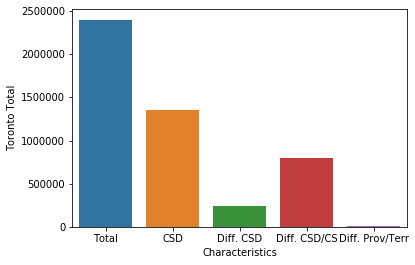

In [394]:
# Destination bar
sns.barplot(x='Characteristics', y='Toronto Total', data=c_dest)

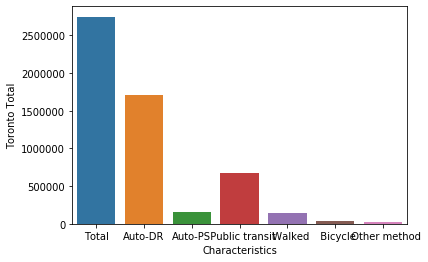

In [395]:
# Modes of commuting bar
sns.barplot(x='Characteristics', y='Toronto Total', data=mode_comm)

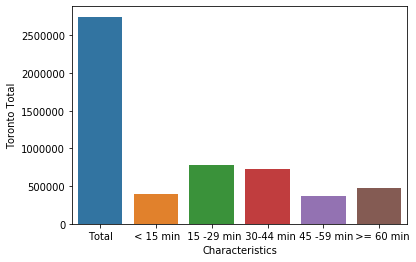

In [396]:
# Commute duration bar
sns.barplot(x='Characteristics', y='Toronto Total', data=c_dur)

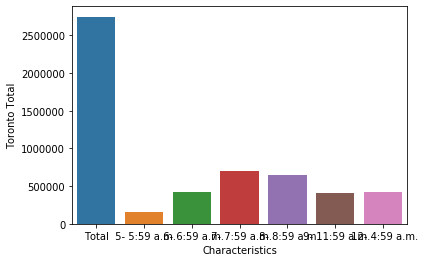

In [397]:
# Time bar
sns.barplot(x='Characteristics', y='Toronto Total', data=time)

#### Make bar charts for Calgary

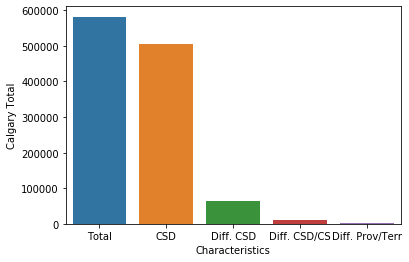

In [398]:
# Destination bar
sns.barplot(x='Characteristics', y='Calgary Total', data=c_dest)

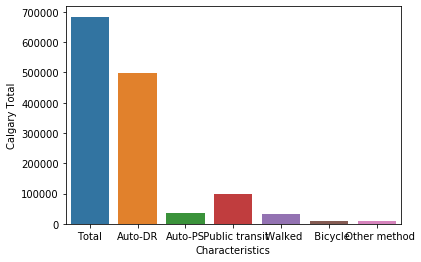

In [400]:
# Modes of commuting bar
sns.barplot(x='Characteristics', y='Calgary Total', data=mode_comm)

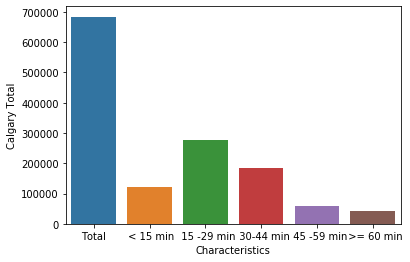

In [401]:
# Commute duration bar
sns.barplot(x='Characteristics', y='Calgary Total', data=c_dur)

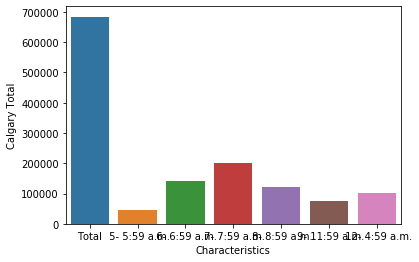

In [402]:
# Time bar
sns.barplot(x='Characteristics', y='Calgary Total', data=time)

### Analyze relationship between modes of transit and greenhouse gas emissions for Toronto and Calgary

#### Visualize Toronto data with ghg for Toronto

In [446]:
# Make separate dataframe for Toronto total for transit
tor_comm = comm.drop(['Topic', 'Calgary Total'], axis=1)

In [447]:
# Get relevant transit data
tor_comm = tor_comm[6:9]

In [448]:
tor_comm

,Characteristics,Toronto Total
6,Auto-DR,1714795.0
7,Auto-PS,154360.0
8,Public transit,667255.0


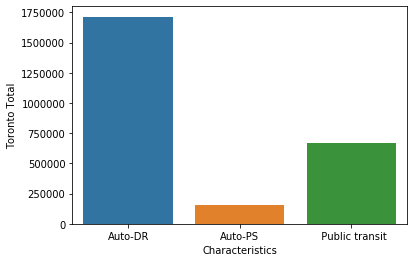

In [449]:
# Make bar graph for Toronto commute
sns.barplot(x='Characteristics', y='Toronto Total', data=tor_comm)

In [457]:
# Separate ghg dataframe for Toronto based on on-road in Transportation sector
ghg_trans_tor = ghg_tor[9:10]

In [458]:
ghg_trans_tor

,Sector,Sub-Sector,Scope 1,Scope 2,Scope 3,Grand Total
9,Transportation,On-road Transportation,"6,266,014",0,"19,066","6,285,080"


In [460]:
print('The total metirc tonnes of CO2 released from Toronto for on-road transportation is: ', ghg_trans_tor['Grand Total'])

The total metirc tonnes of CO2 released from Toronto for on-road transportation is:  9    6,285,080
Name: Grand Total, dtype: object


#### Visualize Calgary data with ghg for Calgary

In [461]:
# Make separate dataframe for Toronto total for transit
cal_comm = comm.drop(['Topic', 'Toronto Total'], axis=1)

In [462]:
# Get relevant transit data
cal_comm = cal_comm[6:9]

In [463]:
cal_comm

,Characteristics,Calgary Total
6,Auto-DR,498360.0
7,Auto-PS,34750.0
8,Public transit,98510.0


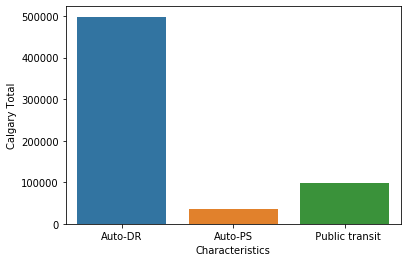

In [464]:
# Make bar graph for Toronto commute
sns.barplot(x='Characteristics', y='Calgary Total', data=cal_comm)

In [475]:
# Separate ghg dataframe for Toronto based on on-road in Transportation sector
ghg_trans_cal = ghg_cal[86:87]

In [476]:
ghg_trans_cal

,year,sector,emissions_source,tonnes_co2e,sector_emissions_source
86,2016,Transportation,On-Road,5968614,TR On-Road


In [477]:
print('The total metirc tonnes of CO2 released from Calgary for on-road transportation is: ', ghg_trans_cal['tonnes_co2e'])

The total metirc tonnes of CO2 released from Calgary for on-road transportation is:  86    5968614
Name: tonnes_co2e, dtype: int64
